# Projet d'Analyse de Spams

Ce notebook suit strictement la structure demandée :
1. **Analyse exploratoire des données**
2. **Traitement des missing values**
3. **Normalisation / standardisation**
4. **Gestion du déséquilibre des classes**
5. **Entraînement et comparaison des modèles**
6. **Évaluation avec métriques adaptées**
7. **Discussion des résultats**

### 0. Imports & Chargement des Données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample

%matplotlib inline

# Chargement
filename = "spam_Emails_data.csv"
if os.path.exists(filename):
    try:
        df = pd.read_csv(filename, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(filename, encoding='latin-1')
    
    # Standardisation des colonnes
    if 'v1' in df.columns: df = df.rename(columns={'v1': 'label', 'v2': 'text'})
    df = df[['label', 'text']]
    print("Données chargées.")
    print(df.head())
else:
    print(f"ERREUR: {filename} introuvable.")

Données chargées.
  label                                               text
0  Spam  viiiiiiagraaaa\nonly for the ones that want to...
1   Ham  got ice thought look az original message ice o...
2  Spam  yo ur wom an ne eds an escapenumber in ch ma n...
3  Spam  start increasing your odds of success & live s...
4   Ham  author jra date escapenumber escapenumber esca...


### 1. Analyse exploratoire des données
Visualisation de la distribution et nuages de mots.

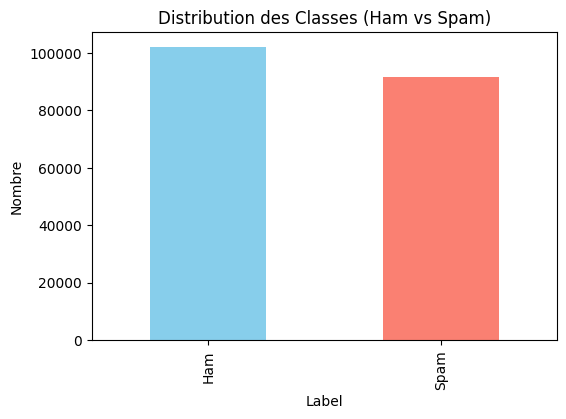

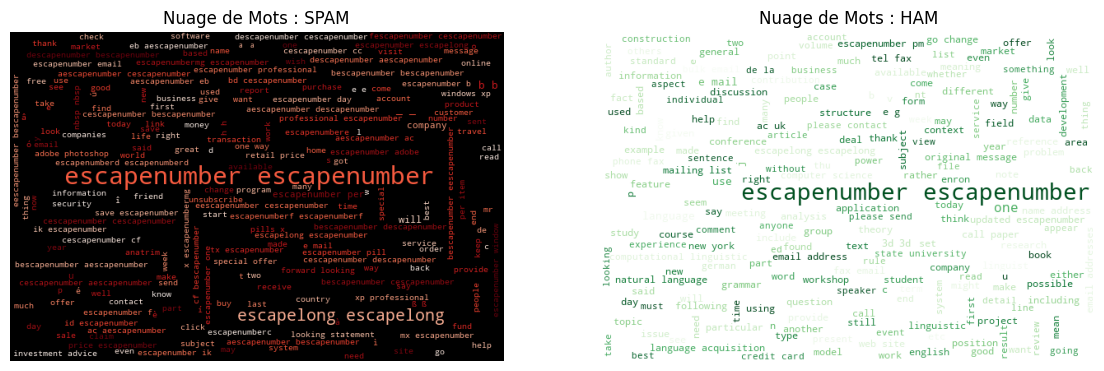

In [ ]:
if 'df' in locals():
    # Distribution
    plt.figure(figsize=(6, 4))
    df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Distribution des Classes (Ham vs Spam)')
    plt.xlabel('Label')
    plt.ylabel('Nombre')
    plt.show()

    # Nuages de mots (Optimisé avec échantillon)
    # On prend un échantillon pour éviter le blocage
    spam_text = ' '.join(df[df['label'] == 'Spam']['text'].astype(str).iloc[:2000])
    ham_text = ' '.join(df[df['label'] == 'Ham']['text'].astype(str).iloc[:2000])
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    if spam_text:
        plt.imshow(WordCloud(width=600, height=400, background_color='black', colormap='Reds').generate(spam_text))
        plt.title('Nuage de Mots : SPAM')
        plt.axis('off')
    
    plt.subplot(1, 2, 2)
    if ham_text:
        plt.imshow(WordCloud(width=600, height=400, background_color='white', colormap='Greens').generate(ham_text))
        plt.title('Nuage de Mots : HAM')
        plt.axis('off')
    plt.show()

### 2. Traitement des missing values

In [12]:
if 'df' in locals():
    print("Valeurs manquantes avant nettoyage :")
    print(df.isnull().sum())
    
    # Suppression des lignes vides
    df.dropna(inplace=True)
    
    # Suppression des doublons
    df.drop_duplicates(inplace=True)
    
    print("Taille après nettoyage :", df.shape)

Valeurs manquantes avant nettoyage :
label    0
text     2
dtype: int64
Taille après nettoyage : (193850, 2)


### 3. Normalisation / standardisation
Utilisation de TF-IDF (Term Frequency-Inverse Document Frequency) pour normaliser les données textuelles.

In [13]:
if 'df' in locals():
    # Encodage binaire
    df['spam_code'] = df['label'].apply(lambda x: 1 if x == 'Spam' else 0)
    
    # Séparation Features / Target
    X = df['text']
    y = df['spam_code']
    
    # Split Train/Test (avant vectorisation pour éviter la fuite de données)
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Vectorisation TF-IDF
    tfidf = TfidfVectorizer()
    X_train_vec = tfidf.fit_transform(X_train_raw.astype(str))
    X_test_vec = tfidf.transform(X_test_raw.astype(str))
    
    print("Dimensions X_train_vec :", X_train_vec.shape)

Dimensions X_train_vec : (145387, 442929)


### 4. Gestion du déséquilibre des classes
Nous allons utiliser l'Oversampling (sur-échantillonnage) de la classe minoritaire (Spam) pour l'entraînement.

In [ ]:
if 'X_train_raw' in locals():
    # 1. Recombiner X et y pour le rééchantillonnage
    train_data = pd.concat([X_train_raw, y_train], axis=1)
    
    # 2. Séparer les classes
    spam_train = train_data[train_data.spam_code == 1]
    ham_train = train_data[train_data.spam_code == 0]
    
    # 3. Oversample Spam
    spam_upsampled = resample(spam_train, 
        replace=True,     # échantillonnage avec remise
        n_samples=len(ham_train), # égaliser avec la classe majoritaire
        random_state=42)
    
    # 4. Combiner
    train_upsampled = pd.concat([ham_train, spam_upsampled])
    
    # 5. Créer les nouveaux sets d'entraînement équilibrés
    X_train_balanced = train_upsampled['text']
    y_train_balanced = train_upsampled['spam_code']
    
    # Distribution après équilibrage
    print("Distribution après Oversampling :")
    print(y_train_balanced.value_counts())
    
    # Vectorisation des données équilibrées
    X_train_balanced_vec = tfidf.transform(X_train_balanced.astype(str))
else:
    print("Données non prêtes.")

Distribution après Oversampling :
spam_code
0    76711
1    76711
Name: count, dtype: int64


### 5. Entraînement et comparaison des modèles
Algorithmes : **Naive Bayes** et **Logistic Regression** sur les données équilibrées.

In [15]:
if 'X_train_balanced_vec' in locals():
    # Modèle 1: Naive Bayes
    nb = MultinomialNB()
    nb.fit(X_train_balanced_vec, y_train_balanced)
    
    # Modèle 2: Logistic Regression
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_balanced_vec, y_train_balanced)
    
    print("Modèles entraînés.")

Modèles entraînés.


### 6. Évaluation avec métriques adaptées

In [16]:
def evaluer(modele, X, y, nom):
    pred = modele.predict(X)
    print(f"--- {nom} ---")
    print("Accuracy :", accuracy_score(y, pred))
    print("\nRapport de Classification :")
    print(classification_report(y, pred))
    print("Matrice de Confusion :")
    print(confusion_matrix(y, pred))
    print("\n" + "="*40 + "\n")

if 'nb' in locals():
    evaluer(nb, X_test_vec, y_test, "Naive Bayes")
    evaluer(lr, X_test_vec, y_test, "Logistic Regression")

--- Naive Bayes ---
Accuracy : 0.9660772135443534

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     25448
           1       0.98      0.94      0.96     23015

    accuracy                           0.97     48463
   macro avg       0.97      0.97      0.97     48463
weighted avg       0.97      0.97      0.97     48463

Matrice de Confusion :
[[25101   347]
 [ 1297 21718]]


--- Logistic Regression ---
Accuracy : 0.9794276045643068

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     25448
           1       0.97      0.98      0.98     23015

    accuracy                           0.98     48463
   macro avg       0.98      0.98      0.98     48463
weighted avg       0.98      0.98      0.98     48463

Matrice de Confusion :
[[24817   631]
 [  366 22649]]




### 7. Discussion des résultats
**Analyse / Comparaison :**
- **Naive Bayes** : Performant pour les textes, rapide, mais suppose l'indépendance des mots.
- **Logistic Regression** : Souvent plus robuste et interprétable, surtout avec des données équilibrées.

Regardez la **Précision** (évite les faux positifs, important pour ne pas bloquer les mails légitimes) et le **Rappel** (évite les faux négatifs, important pour bien filtrer le spam). Le modèle avec le meilleur score F1 est souvent le meilleur compromis.